# Использование моделей АРСС

Один из методов, доступных моделирования и прогнозирования временных рядов, известен как [`SARIMAX`](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html), что означает сезонное авторегрессионное интегрированное скользящие средние с экзогенными регрессорами. В частности могут быть такие подвиды модели, как:
* `AR` (**A**uto**R**egressive);
* `MA` (**M**oving **A**verage);
* `SAR` (**S**easonal **A**uto**R**egressive);
* `SMA` (**S**easonal **M**oving **A**verage);
* `ARMA` (**A**uto**R**egressive-**M**oving **A**verage);
* `ARIMA` (**A**uto**R**egressive-**I**ntegrated-**M**oving **A**verage);
* `SARIMA` (**S**easonal **A**uto**R**egressive-**I**ntegrated-**M**oving **A**verage);
* `SARIMAX` (**S**easonal **A**utoRegressive-**I**ntegrated-**M**oving **A**verage with e**X**ogenous factors).

<!-- В общем случае модель `SARIMAX` имеет и другие частные случаи.  -->
Мы рассмотрим вариант [`SARIMA`](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html).

Отметим, что могут быть и другие модели на основе <tt>ARIMA</tt> и  [ее модификаций](https://pyflux.readthedocs.io/en/latest/gas.html) для более сложных процессов или процессов иной природы, например процессов [волатильности](https://github.com/bashtage/arch).

Семейство моделей [`SARIMAX`](https://gowrishankar.info/blog/a-practical-guide-to-univariate-time-series-models-with-seasonality-and-exogenous-inputs-using-finance-data-of-fmcg-manufacturers/) относится к методам параметрической статистики. То есть свойства модели, в том числе, точность ее приближения к данным задаются набором параметров модели. В данном случае параметры называются порядком модели. Могу быть заданы отдельно порядок авторегресионной части модели; порядок скользящего среднего; порядок интегрирования (дифференцирования) и т.д.

Подход  `SARIMAX` был предложен Боксом-Дженкинсом. Методология подхода включает следующие пункты:
* **Идентификация модели**: используйте графический метод и методы сводной статистики для определения характера тренда и сезонности. А также, чтобы получить представление о порядке производной ($d$) и порядках авторегрессии $p$  и $q$ скользящего среднего.
* **Оценка модели**: оценка коэффициентов регрессионной модели.
* **Диагностика модели** максимального правдоподобия: используйте графический метод и статистические тесты остаточных ошибок (разности), чтобы определить особенности данных, не охваченной моделью.



Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    import sktime
except:
    !pip install sktime --user
    !pip install pmdarima
    !pip install statsmodels
    !pip install prophet
import sktime

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [4]:
from sktime.utils.plotting import plot_series
from sktime.transformations.series.detrend import Deseasonalizer

from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima   import ARIMA, AutoARIMA
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.base   import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arch import StatsForecastARCH, StatsForecastGARCH
from sktime.forecasting.model_selection import temporal_train_test_split


from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter("ignore", FutureWarning)

Импорт данных аналогично предыдущего урока.

Check splitted data size: Train: 170, Test: 91


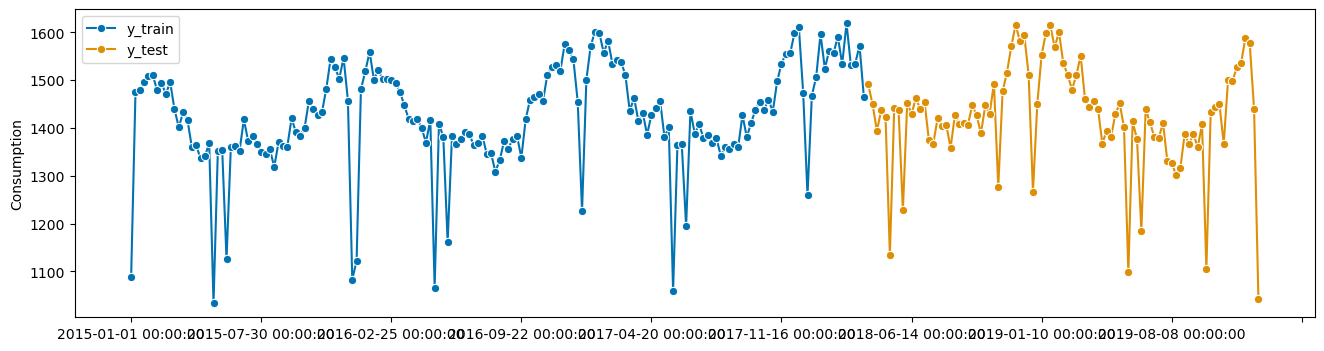

In [6]:
path_ts = 'de_data.csv'

df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
df=df.fillna(df.mean())

y = df.Consumption.asfreq('7d')

TEST_SIZE = int(0.35*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

plot_series(y_train, y_test, labels=["y_train", "y_test"]);


## SARIMA Forecasting

Для модели [`AutoregRessive Integrated Moving Average` (`ARIMA`)](https://otexts.com/fpp3/non-seasonal-arima.html) существует три  параметра (порядка) [(`p, d, q`)](https://nixtlaverse.nixtla.io/statsforecast/docs/models/arima.html):
* `p` - **авторегрессивная часть модели**. Этот параметр позволяет учесть влияние прошлых значений на текущее для модели. Прошлые значения здесь называются запаздывающими наблюдениями (также известными как «запаздывание» или «лаг»). Интуитивно это похоже на утверждение, что завтра, вероятно, будет тепло, если в последние 3 дня было тепло. Другими словами, здесь мы можем сказать, что текущее значение температуры зависит от последних трех значений.

* `d` – **интегрирование модели**. Этот параметр включает в себя степень различия лагов (то есть количество прошлых временных точек, которые нужно вычесть из текущего значения), чтобы сделать временной ряд стационарным (чтобы исключить часть тренда). Интуитивно это было бы похоже на утверждение о том, что, вероятно, будет одно и то же повышение температуры каждый день (или одно и то же ускорение для второй производной и т.д.).

* `q` - **скользящая средняя часть модели**. Этот параметр позволяет представить остаточную часть (шум, ошибку) модели как линейную комбинацию остаточных значений, наблюдаемых в предыдущие моменты времени.

Если в модели видно достаточно сильное влияние сезонной составляющей, то следует перейти к модели `ARIMA` с сезонными эффектами (`Seasonal ARIMA - SARIMA`).  Как правило такая модель обозначается как 
$$SARIMA (p, d, q) (P, D, Q) s.$$ 
Где
* (`p, d, q`) -  несезонные параметрами, описанными выше; 
* (`P, D, Q`) - сезонные порядки, которые следуют тому же порядку определений как и описанные выше, но применяются к [сезонной составляющей временного ряда](https://otexts.com/fpp3/seasonal-arima.html);
* `s` - это периодичность временного ряда (например, $4$ для квартальных периодов, $12$ для годовых периодов и т.д.).

Рассмотрим процедуру ручного выбора порядков модели. Как правило, [начинать следует с достижения стационарности](https://openforecast.org/adam/ARIMAIntro.html). Как правило, это достигается путем дифференцирования $1--3$ порядок, реже - больше. Отметим, что иногда перед этой процедурой также потребуется проведения преобразования Бокса-Кокса или другой тип преобразования для устранения, например, эффектов валатильности.

Правильный порядок дифференцирования (`d, D`) это порядок разности, который делает временной ряд шумоподобным
т.е. значения колеблется около четко определенного среднего и имеют почти постоянный разброс значений. При этом рекомендуется использовать сезонную производную только в случае сильного сезонного влияния.


Для [проверки стационарности](https://otexts.com/fpp3/stationarity.html) после дифференцирования можно использовать несколько методов, в том числе:
* **Скользящая статистика**: построение скользящего среднего и скользящего стандартного отклонения. Идея этого метода в том, что временные ряды являются стационарными, если они остаются неизменными во времени. Скользящая статистика визуально показывает стационарность среднего значения.
* **Статистические тесты, в т.ч. Расширенный тест Дики-Фуллера**. 
Тест на стационарность обычно включает проверку где нулевая гипотеза `𝐻0` заключается в том, что ряд нестационарен. Альтернативная гипотеза `𝐻1`  подтверждает стационарность.  Примерами таких тестов могут быть тест Дика-Фуллера ( и его расширенная версия <tt>ADF</tt>) или например тест <tt>Kwiatkowski-Phillips-Schmidt-Shin (KPSS)</tt>. В рамках этих тестов оценивается специальная статистика, которая сравнивается с табличными значениями или пересчитывается в уровень значамости (`p-value`). \\
Временной ряд считается стационарным, если значение `p-value` низкое (в соответствии с нулевой гипотезой), а критические значения с доверительными интервалами $1%, 5%, 10%$ максимально близки к табличному значению параметра `ADF` (<tt>к т.н. статистике ADF</tt>). Если тест `ADF` показывает, что статистика `ADF` далека от критических значений, а значение `p-value` превышает пороговое значение (например, $0,05$), то ряд  является стационарным. В обратном случае ряд следует признать стационарным.

> Другими словами (возможно более правильно) было бы сказать, что небольшое значение `p-value` ($p<0,05$) указывает на  доказательства против нулевой гипотезы теста. Например, очень высокое `p-value`$0,99$,  дает слабые доказательства против нулевой гипотезы, поэтому вероятно следует решить, что  набор данных не является стационарным. Если `p-value` очень мало, например $0.0005$ можно отвергать нулевую гипотезу, принимая что ряд стационарный. 
>Отметим, что  в статистике  ничто никогда не бывает по-настоящему доказано. То есть можно только отвергать или принимать гипотезу с заданной степенью уверенности.
   > При этом нестационарность подразумевает наличие т.н. единичного корня (`unit root`) или порядка интеграции один. То есть предполагается что временные разности ВР образуют стационарный ряд. Расширенные версии тестов (<tt>ADF</tt>) могут включать порядки интеграции выше 1-го.
   
   > [Отметим](https://openforecast.org/adam/BJApproach.html), что  `ADF` тетс основан на оценке параметров `AR`-модели и последующей проверке гипотезы для этих параметров, а `KPSS` тест включает в модель компонент случайного блуждания (с потенциальным трендом) и проверяет, равна ли дисперсия этого компонента нулю или нет. Оба теста имеют свои преимущества и недостатки и иногда могут противоречить друг другу. [Более того](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html):
   >* Тест `KPSS` подразумевает наличие тренда (в т.ч. случайного); низкое `p-value` указывает на нестационарность из-за тренда.
   >* Тест `ADF` подразумевает наличие т.н. `единичного корня`, и низкое значение `p-value` указывает на то, что временной ряд не имеет этого единичного корня, что позволяет предположить, что он является стационарным.
   
   > Также отметим, что отклонение или принятие нулевой гипотезы (`𝐻0`) не означает что это $100%$ правда. Правильное формулировкой ответов должно быть <tt>"мы не можем отклонить гиптоезу `𝐻0`, так как она подтверждается тестом"</tt>.
   
<!--  A test for stationarity usually involves a unit root hypothesis test, where the null hypothesis  𝐻0
  is that the series is nonstationary, and contains a unit root. The alternate hypothesis  𝐻1
  supports stationarity. The augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests are stationarity tests. -->


Проверим стационарность для нашего ряда. Для этого используем метод [`rolling`](https://www.datasource.ai/en/data-science-articles/4-must-know-python-pandas-functions-for-time-series-analysis). Результат окна аггрегируем при помощи срденего и СКО. Таким образом получим два ВР. В какой то степени проводимый анализ [явялется разведовательным](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html) для задач `ARIMA`

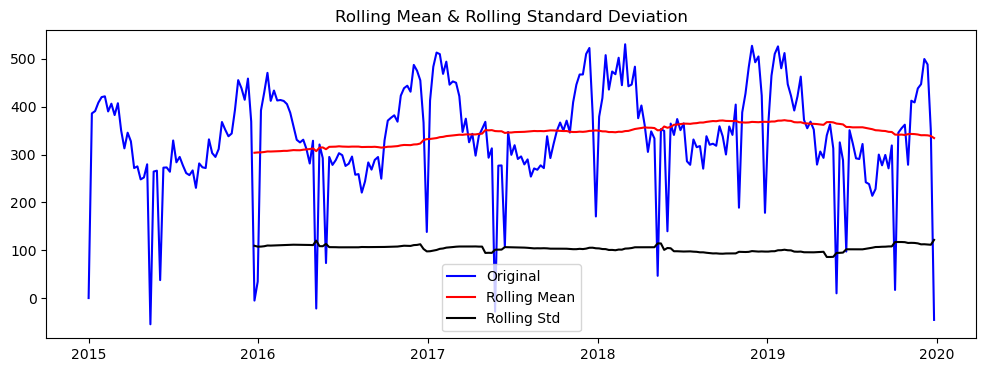

In [7]:
rolling_mean = y.rolling(window = 52).mean()
rolling_std  = y.rolling(window = 52).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y-y[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-y[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Также проверим стационарность при помощи [теста Дика-Фуллера](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html). Для этого мы напишим [функцию проверки](https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoregressive.html).

In [8]:
P_THRESHOLD = 0.01
def check_ADF(y, p_threshold = P_THRESHOLD):
    print('Augmented Dickey-Fuller Test')
    result = adfuller(y,autolag='AIC')
    adf_value = result[0]
    p_value   = result[1]
    lags_used = result[2]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('lags_used: {:.1f}'.format(lags_used))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))    
    print(f'Result: The series is {"not " if p_value > p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

Augmented Dickey-Fuller Test
ADF Statistic: -3.8786
p-value: 0.0022
lags_used: 2.0
Critical Values:
	1%: -3.4701, 
	5%: -2.8790, 
	10%: -2.5761, 
Result: The series is stationary


В данной ситуации получилось, что ряд стационарен в соответствии с тестом. Однако, на графике мы видим небольшие (сравнительно) отклонения от стационарности. В этом случае стационарности можно добиться дифференцированием. Рассмотрим обычное дифференцирование. В нашем случае это означет численную производную  $\Delta y(t) = y(t) - y(t-1)$. Отметим, что размер такой выборки на выходе на $1$ отсчет меньше чем исходной. В нашем случае такой семпл будет `NaN`. Поэтому мы его удаляем.

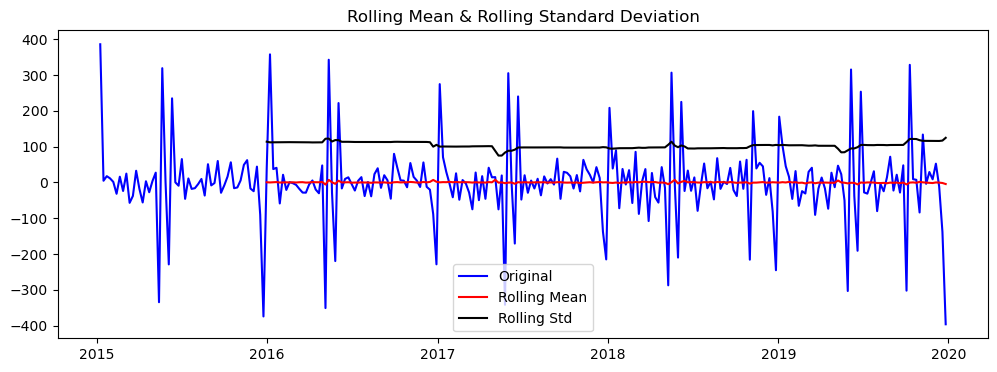

Augmented Dickey-Fuller Test
ADF Statistic: -8.9391
p-value: 0.0000
lags_used: 6.0
Critical Values:
	1%: -3.4565, 
	5%: -2.8730, 
	10%: -2.5729, 
Result: The series is stationary


In [9]:
y_diff = y[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 52).mean()
rolling_std  = y_diff.rolling(window = 52).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

<!-- 
Попробуем несколько вариантов с использованием сезонного дифференцирования. Отметим, что мы подобрали оптимальный период дифференцирования, который соответствует 3 месяцам  (13 недель). В общем случае следует начинать с наиболее очевидного значения периода (например 1 год = 52 недели), но всегда можно попробовать несколько вариантов. Если выбран  Для выбора периода можно использовать, например, следующий код.
 ```python 
for s in range(1,52): #month, 3 month, quarter, half-year, year  
    p_value = adfuller(y_train[:].diff(s).dropna())[1]
    if  p_value> P_THRESHOLD: print(f'season {s}, p-value {p_value:.4f}')
```
В результатах выше 11 лаг максимален, однако предположительно интерпретировать мы можем лишь 13 лаг (3 месяца). Посмотрим, как выглядят графики для этого лага
-->

Достигнутый результат имеет некоторые признаки нестационарности. Возможно признаки не значительны. Однако, попробуем также модель с сезонным дифференцированием для сравнения: $\Delta_sy(t)=y(t) - y(t-s)$. Отметим, что в случае такого дифференцирования результирующая выборка сокращается на $s$ отсчетов.

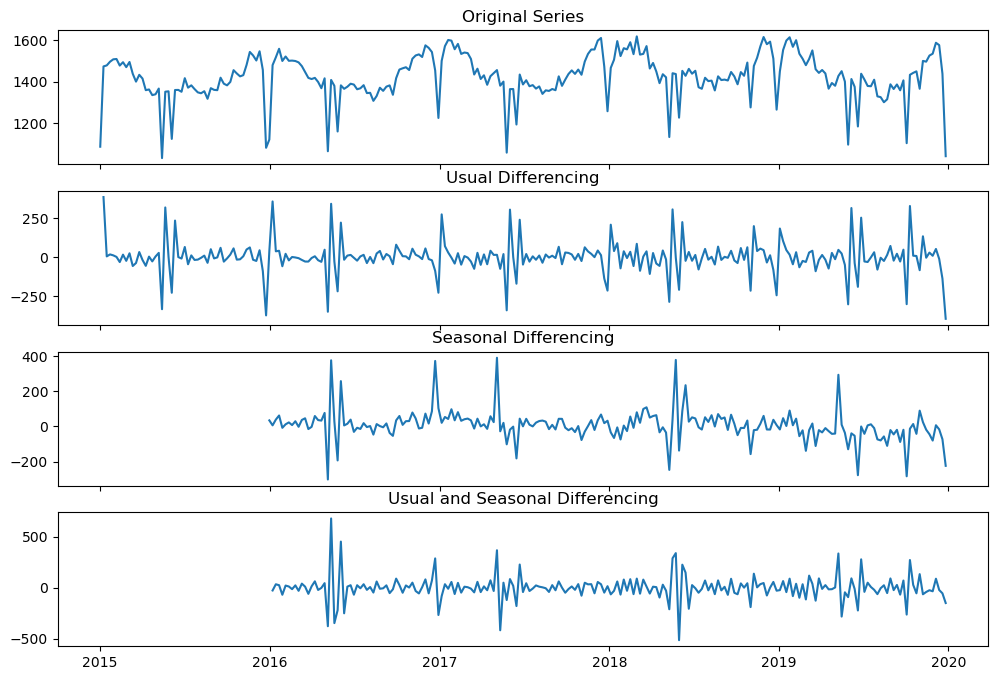

In [10]:
SEASON = 52

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.show()

Сезонная производная не изменила ситуации. Из проведенного анализа мы можем заключить что предварительной оценкой порядков дифференцирования (интегрирования) являются: $d=1; D=0; s=52$. 

После выбора порядков дифференцирования следует перейти к оценке порядков авторегрессии и скользящего среднего. Как правило, [в ручную](https://otexts.com/fpp3/arima-estimation.html), эти параметры выбираются при помощи автокорреляционной и частичной автокорреляционной функций (`ACF` и `PACF` соответственно).

Как правило, графики `ACF` и `PACF` состоят из точек, соответствующих значениям этих функций для т.н. "лагов" - то есть значений вычисленных для т.н. "запаздывания" одной из копий функции относительно другой (см. определение `ACF` и `PACF`). Также на графиках обычно отображают доверительные интервалы, которые имеют вид конуса в районе нуля. Эти интервалы показывают порог проверки гипотезы о белом шуме. Другими словами все значение ниже уровень доверительного интервала скорее всего не имеют статистической значимости.  По умолчанию  установлен доверительный интервал 95%, что предполагает, что значения корреляции за пределами этого интервала, скорее всего, являются корреляцией, а не статистической случайностью.

При  ручном выборе порядков модели рекомендуются [следующие правила](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html):
* **Количество слагаемых [`AR`](https://otexts.com/fpp3/AR.html) [(AR порядок)](https://phdinds-aim.github.io/time_series_handbook/01_AutoRegressiveIntegratedMovingAverage/01_AutoRegressiveIntegratedMovingAverage.html)** определяется как [последнее значение лага `PACF`](https://phdinds-aim.github.io/time_series_handbook/01_AutoRegressiveIntegratedMovingAverage/01_AutoRegressiveIntegratedMovingAverage.html#finding-the-order-of-the-autoregressive-term-p) перед быстрым уменьшением от положительных значений до нуля.
* **Количество слагаемых скользящего среднего ([`MA`](https://otexts.com/fpp3/MA.html))** определяется как последнее значение лага `ACF` перед быстрым увеличением от отрицательных значений до нуля [или наборот по резкому спаду](https://phdinds-aim.github.io/time_series_handbook/01_AutoRegressiveIntegratedMovingAverage/01_AutoRegressiveIntegratedMovingAverage.html#finding-the-order-of-the-moving-average-term-q) от положительных значений до нуля.
* **Добавьте слагаемое `SAR`**, если значения `PACF` периодически положительны. 
* **Порядок `SAR`** может быть оценен из `PACF`. Посмотрите на количество значений лагов выше уровня шума, которые кратны периоду сезона. Например, если период равен `24`, и мы видим, что `24-е` и `48-е` запаздывания значительны в `PACF`, это означает, что начальное `P` должно быть `2`.
* **Добавьте член `SMA`**, если значения `ACF` периодически отрицательный.
* **Порядок `SMA`** может быть оценен из `ACF`. Посмотрите на количество отрицательных значений лагов выходящих за уровень шума, которые кратны периоду сезона. 
* Если временной ряд немного недодифференцирован, добавьте дополнительное слагаемое в `AR`.
* Если ваши ряды немного передифференцирован, добавьте дополнительные слагаемое в `MA`.
* Старайтесь избегать использования более одного или двух сезонных порядков (`SAR + SMA`) в одной модели, так как это может привести к переобучению данных и/или проблемам в точности оценок.
* Если все значения `ACF` и `PACF` кроме `0` не выходят за доверительный интервал следует считать модель белым шумом.

Рассмотрим графики `ACF` и `PACF`.

https://github.com/cuge1995/awesome-time-series https://github.com/lmmentel/awesome-time-series

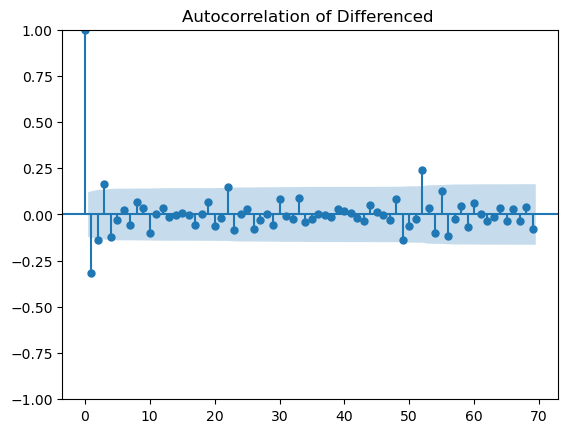

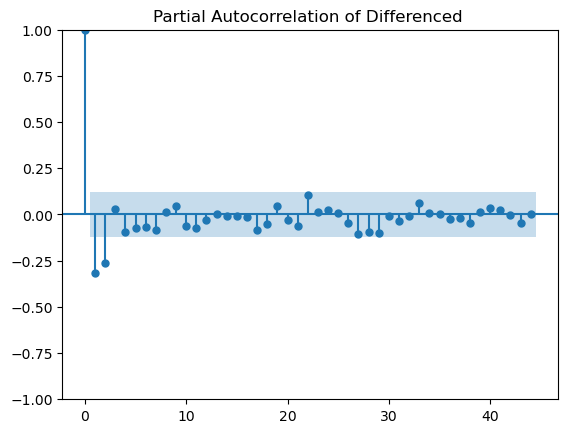

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Usual Differencing
plot_acf(y_diff, title='Autocorrelation of Differenced ', lags=np.arange(70) );plt.show()
# Usual Differencing
plot_pacf(y_diff, title='Partial Autocorrelation of Differenced ', method='ywm', lags=np.arange(45));plt.show()
plt.show();

Из графиков выше следует следующий выбор параметров.
* $2$ порядка `AR`  ($2$ лаги `PACF` ниже нуля); 
* $1$ порядок `MA`  (на `ACF` видна некоторая нестационарность, но 1 и 2 лаги не превысили доверительный интервал);
* $1$ порядок `SAR` (`PACF` нет значимых лагов выше нуля? но на `ACF` один есть);
* $0$ порядок `SMA` (на `ACF` нет значимых лагов ниже нуля);
* Ряд немного недодифференцирован, поэтому установим $3$ порядок `AR`; 

Теперь давайте проверим модель $SARIMA (3,1,0)(0,0,0)_{52}$ Напомним, что после оценки предварительных параметров модели, чаще всего, необходимо провести  некоторую до настройку (подбор) значений параметров. Это делается по нескольким критериям, в том числе особым критериям выбора порядка `ARMA` моделей, например [`BIC, AIC`](https://search.r-project.org/CRAN/refmans/weakARMA/html/ARMA.selec.html) и т.д.     
Отметим, что в данном случае мы будем рассматривать класс [`SARIMAX`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.sarimax.SARIMAX.html) из пакета `SKTime`. Данный пакет основан на функциях из библиотеки [`statsmodels`](https://www.statsmodels.org/stable/index.html).

Также отметим, что дополнительно при анализе результатов мы будем пользоваться информацией метода `summary`. Метод представляет достаточно обширую [сводку параметров](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html). В том числе тут показаны значения информационных критериев (<tt>AIC, BIC и  HQIC</tt>), [которые позволяют](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-3/) сравнить модели друг с другом, а также `sigma2` – это `RSS` (средне квадратическая) ошибка модели; набор коэффициентов модели и их параметры; а также анализ остатков модели. В [том числе](https://jadsmkbdatalab.nl/forecasting-with-sarimax-models/) тесты [`Ljung-Box`](https://www.statology.org/ljung-box-test/) и [`Jarque-Bera`](https://dataaspirant.com/jarque-bera-test/), а также тест на [гетеросекдостичность](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity). Первый тест говорит о налчисии корреляций в остатках, а второй о нормальном распределении остатка.

> [Напомним](https://netman.aiops.org/~peidan/ANM2019/5.KPIAnomalyDetection/ReadingLists/time_series.pdf), что информационные критерии представляют собой метрики сравнения моделей одного класса но с разными параметрами, тестируемые на одном наборе данных. Смысл информационных критериев сводится к задаче поиска компромисса между точностью на тренировочной выборки и сложностью модели. То есть числом параметров.  \
> Чем  меньше параметров, тем эвристически больше обобщающая способность. То есть меньше вероятности переобучить систему.  \
> Таким образом информационный критерий сводит задачу к минимаксной! \
> В общем случае помимо указанынх критериев могут быть и другие. Однако, указанные наиболее популярные в задаче поиска парамтров [`ARMA` моделей](https://search.r-project.org/CRAN/refmans/smoots/html/critMatrix.html).

In [12]:
forecaster = SARIMAX(order=(3, 1, 1), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Consumption   No. Observations:                  170
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 52)   Log Likelihood                -680.375
Date:                             Thu, 14 Mar 2024   AIC                           1372.750
Time:                                     18:51:47   BIC                           1389.323
Sample:                                 01-01-2015   HQIC                          1379.479
                                      - 03-29-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0781      0.289     -0.270      0.787      -0.645       0.488
ar.L1         -0.1244      

В полученных в `summary` результатах можно сделать [следующие выводы](https://jadsmkbdatalab.nl/forecasting-with-sarimax-models/): $Prob(Q) > 0.05$ ->  Мы **не можем** отвергать нулевую гипотезу (о том, что остатки некоррелированы). То есть предполагаем, что **остатки не коррелированы**.
$Prob(JB) < 0.05$ -> Мы **отвергаем нулевую гипотезу** (о том, что остатки распределены нормально). Следовательно, **остатки не являются нормально распределенными**.  $Prob(H) <0.05$ -> Мы **отвергаем нулевую гипотезу** (об отсутствии гетеросекдостичности). Следовательно **гетеросекдостичность присутствует в остатках** в какой то мере.

Помимо табличного представления, мы можем проводить [диагностику остатков](https://otexts.com/fpp3/residuals.html) графическим способом. Напомним, что остатки в данном контексте означают разность модели, аппроксимированной при помощи `SARIMA` и тренировочных данных.
Отметим, что данный способ не является стандартным методом класса `SARIMAX`, однако присутствует в нем.

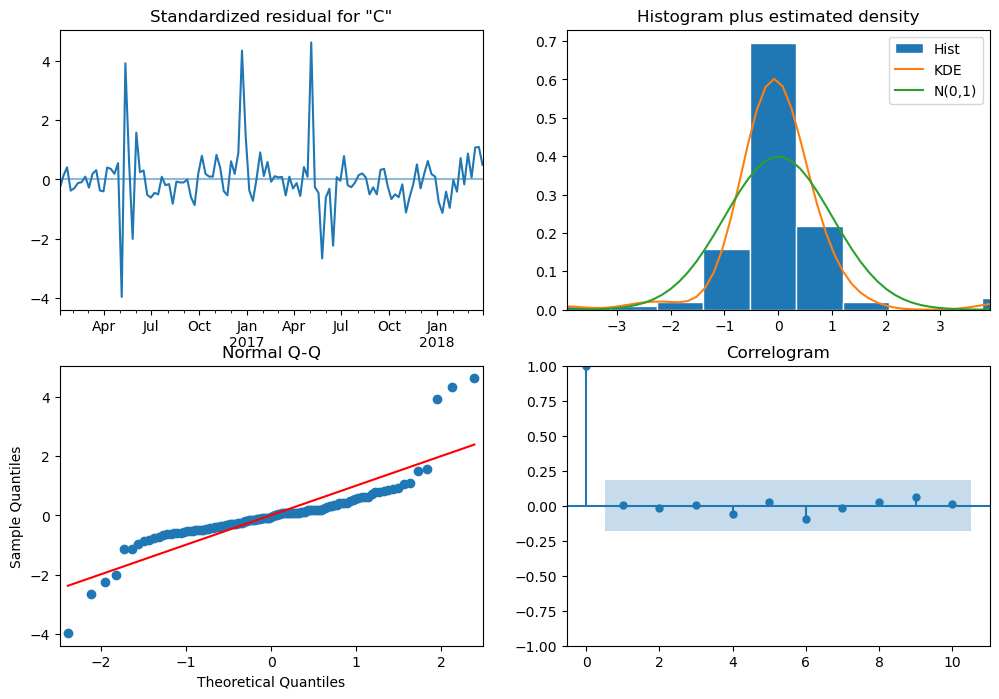

In [36]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

На графиках выше [мы видим](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3):
* **верхний левый  график**: остаточные ошибки колеблются около нулевого среднего, однако имеют несколько не равномерную дисперсию, возможно модель недодифференцирована.
* **верхний правый график**: остаток имеет распределение, похожее на нормальное распределение, но с большими "хвостами". 
* **нижний правый график**: график `Q-Q` показывает отклонения от нормального распределения. 
* **нижний левый график**: автокорреляционная функция не показывает значительных (статистически значимых) отличий от нормального распределения. 

Проведенный [анализ](https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting) показывает, что мы можем улучшить нашу модель. При ручном поборе порядка модели следует отдавать предпочтения моделям с наименьшим значением критериев качества и с наименьшей ошибкой `RSS`.

В качестве первого предположения мы можем попытаться увеличить порядок дифференцирования модели.  После можно попробовать несколько значений разных порядков.

sMAPE = 0.048


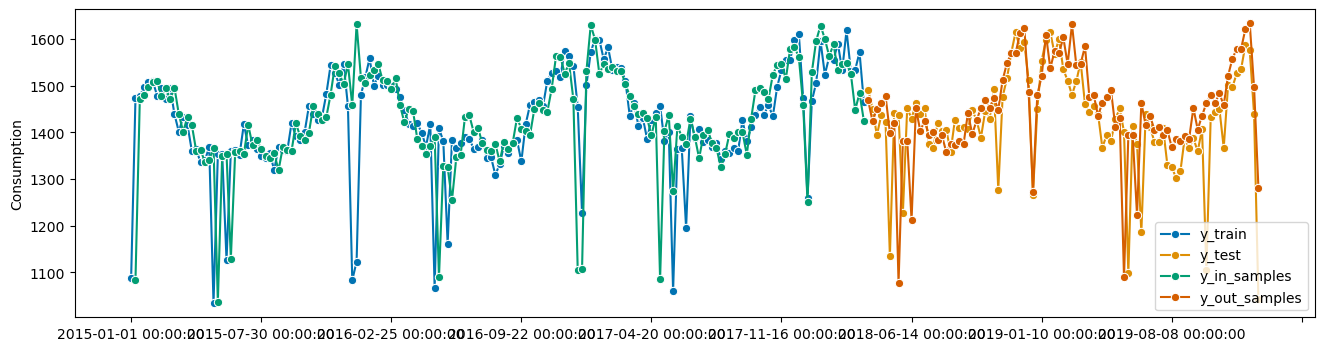

In [37]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

                                      SARIMAX Results                                      
Dep. Variable:                         Consumption   No. Observations:                  170
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 52)   Log Likelihood                -986.248
Date:                             Thu, 14 Mar 2024   AIC                           1984.496
Time:                                     18:55:46   BIC                           2003.275
Sample:                                 01-01-2015   HQIC                          1992.117
                                      - 03-29-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3127      1.285      0.243      0.808      -2.206       2.831
ar.L1          0.0203      

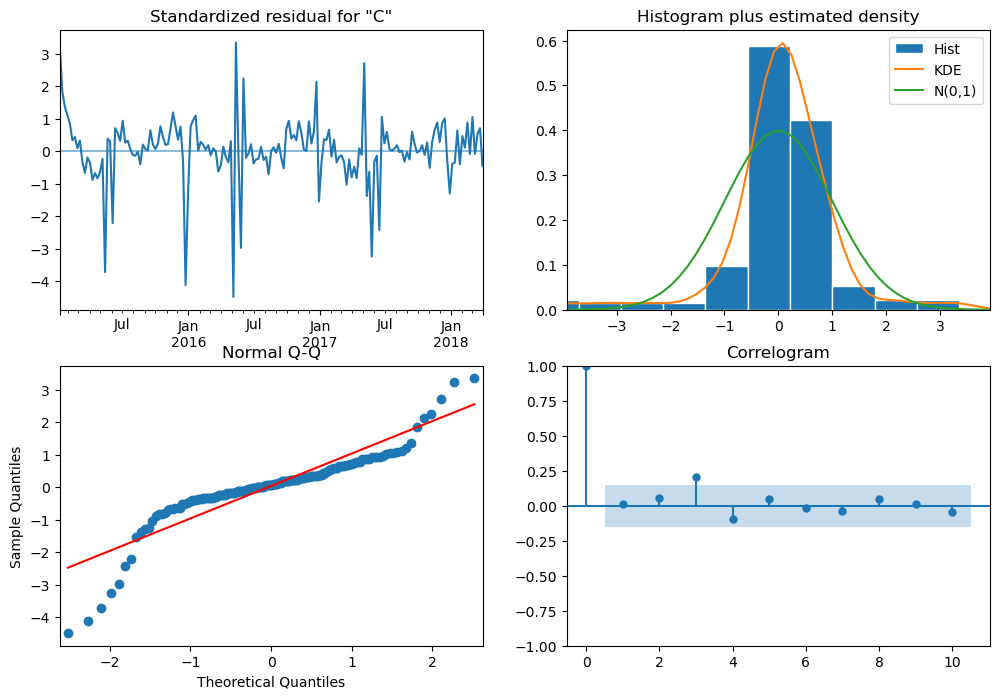

In [15]:
forecaster = SARIMAX(order=(2, 1, 1), seasonal_order=(1, 0, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

Теперь давайте попробуем визуализировать предсказания нашей модели. Тут важно заметить, что мы будем отдельно строить прогноз внутри тренировочной выборки (`in-samples prediction`) и отдельно строить предсказания, сравниваемые с тестовой выборокй (`out-of-samples forecasting`). Предсказания внутни выборки нужны тут в качестве некоторого само-теста (`backtest`). По такой методике можно дополнительно подбирать гиперпараметры модели, если нет валидационной выборки. Однако, отметим, что тут как и в глубоком обучении нейронных сетей может сложиться ситуация переобучения.

sMAPE = 0.082


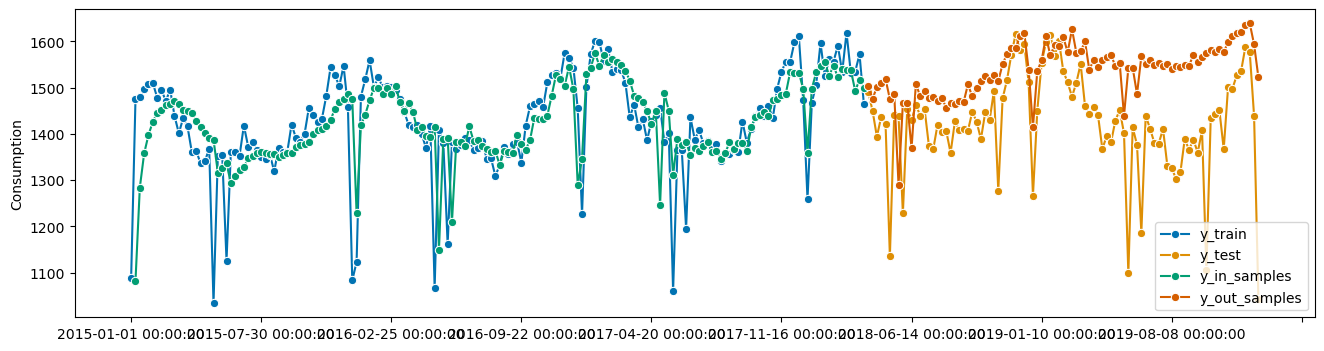

In [16]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

 Полученный результаты не достаточно хорошо описывают модель.  Рискнем предположить, что можно достичь и лучшей аппроксимации. 
 
Отметим что помимо полученных значений предсказаний важно и [предсказание их дисперсии](https://otexts.com/fpp3/arima-forecasting.html). Давайте попробуем построить такие интервалы.

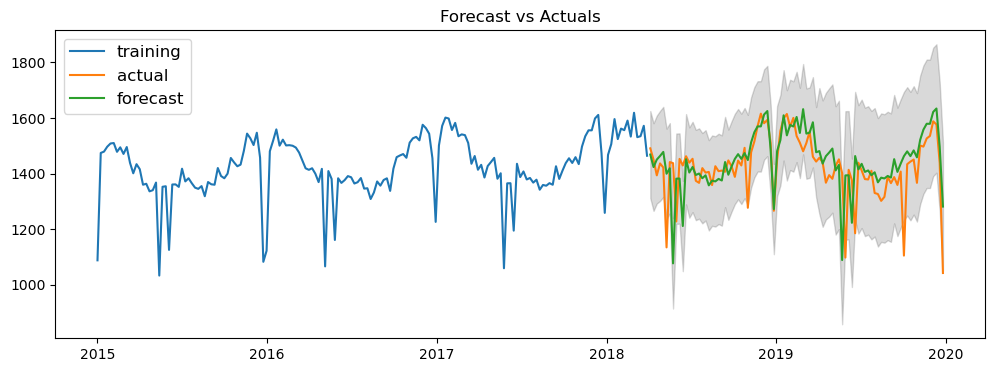

In [20]:
forecaster = SARIMAX(order=(3, 1, 1), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train)
# print(forecaster.summary())
# forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

# Forecast
forecast_res = forecaster._fitted_forecaster.get_forecast(y_test.size, alpha=0.01, dynamic=False)  # 95% conf

forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=y_test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower Consumption'], index=y_test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper Consumption'], index=y_test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train, label='training')
plt.plot(y_test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()


## AUTO ARIMA

Поиск [параметров моделей ARIMA](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/) представляет собой сложную задачу, которая на практике не имеет однозначного решния. 
Во многих случаях, для упрощения поиска параметров `ARMA` могут быть использованы [подходы автопоиска параметров модели](https://otexts.com/fpp3/arima-r.html). Такой подход также будет основан на [анализе информационных критериев](https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#arima-family-crash-course). Мы рассмотрим один из таких инструментов в рамках пакета `SKTime` это `AutoARIMA`. Данный класс основан функциях из библиотеки [`pmdarima`](http://alkaline-ml.com/pmdarima/).

Объект класса `AutoARIMA` позволяет задать границы поиска параметров моделей, а также метод тестирования и ряд других параметров. В качестве примера давайте попробуем найти автоматическое предложение параметров.

In [73]:
model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=0,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=5,    # конечный порядок MA                 
                  seasonal=True,  # Использовать SARIMA  
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA                 
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 7, # Максимальный порядок p+q+P+Q 
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',  
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=1419.944, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=1464.278, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=1415.176, Time=2.24 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1462.279, Time=0.32 sec
 ARIMA(1,1,0)(2,1,0)[52] intercept   : AIC=inf, Time=12.64 sec
 ARIMA(1,1,0)(1,1,1)[52] intercept   : AIC=inf, Time=8.71 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=1415.064, Time=3.32 sec
 ARIMA(1,1,0)(0,1,2)[52] intercept   : AIC=inf, Time=16.86 sec
 ARIMA(1,1,0)(1,1,2)[52] intercept   : AIC=inf, Time=21.00 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=8.82 sec
 ARIMA(2,1,0)(0,1,1)[52] intercept   : AIC=1381.418, Time=4.54 sec
 ARIMA(2,1,0)(0,1,0)[52] intercept   : AIC=1388.035, Time=0.68 sec
 ARIMA(2,1,0)(1,1,1)[52] intercept   : AIC=inf, Time=10.04 sec
 ARIMA(2,1,0)(0,1,2)[52] intercept   : AIC=inf, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  170
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 52)   Log Likelihood                -685.715
Date:                              Tue, 27 Feb 2024   AIC                           1379.430
Time:                                      19:07:20   BIC                           1390.479
Sample:                                  01-01-2015   HQIC                          1383.916
                                       - 03-29-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7864      0.055    -14.277      0.000      -0.894      -0.678
ar.L2         -0.5131      0.057     -8.937      0.000      -0.626      -0.401
ma.S.L52      -0.5811      0.149     -3.896      0.000      -0.873      -0.289
sigma2      6063.2405    655.246      9.253      0.000    4778.982    7347.499
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               324.06
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

И так протестируем модель, выбранную автоматически.

sMAPE = 0.075


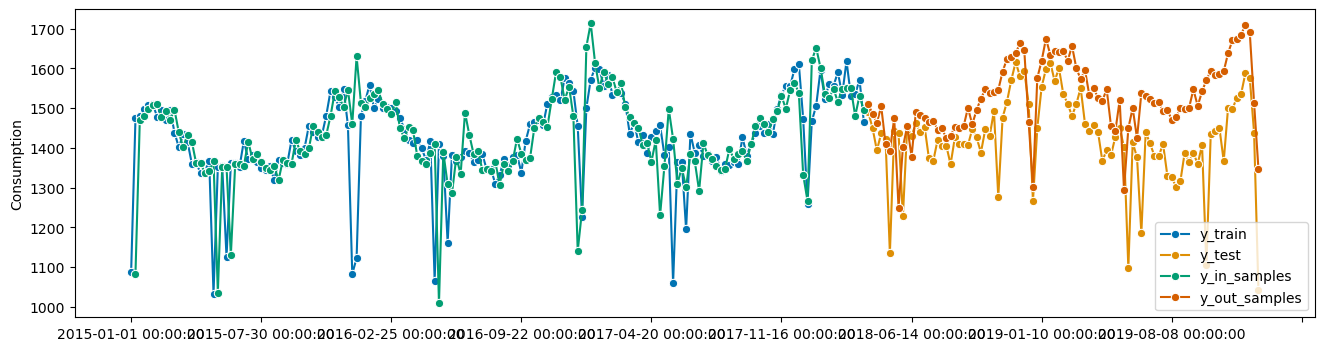

In [75]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = model.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = model.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Полученная модель оказалась не лучше найденной вручную. Однако, подчеркнем, что на практике такое не всегда бывает. В частности, можно заметить, что критерий `AIC` для модели, подобранной вручную был несколько ниже, чем для проверенных автоматически. Часто, авто поиск модели можно использовать лишь как некоторое очень хорошее [начальной предположение](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python).
> Отметим, что инфромационные критерии применимы только когда используются на одних [и тех же данных!](https://robjhyndman.com/hyndsight/aic/) Поэтому, в частности, порядок дифференцирования в процедурах автопоиска задается автоматически. 

Помимо интерфейса для pmdarima пакет `sktime` также включает возможность использовать оригинальный фреймворк  [`StatsForecastAutoARIMA`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoARIMA.html) от авторов [nixtla](https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html). Давайте также протестируем этот вариант.

In [78]:
model = StatsForecastAutoARIMA(start_p=1,  # начальный порядок AR
                              d=1,        # Порядок производной
                              start_q=0,  # начальный порядок MA
                              max_p=5,    # конечный порядок AR
                              max_q=5,    # конечный порядок MA                 
                              seasonal=True,  # Использовать SARIMA  
                              start_P=0,  # начальный порядок SAR
                              start_Q=0,  # начальный порядок SMA                 
                              D=1,        # Порядок сезонной производной
                              sp=52,      # Период сезонности
                              max_order = 7, # Максимальный порядок p+q+P+Q 
                              trace  = True,   # отчет он-лайн
                              stepwise = True, # метод ускоренного выбора параметров.
                              n_jobs = 1,      # для stepwise парралелизм не доступен.
                              )

model.fit(y_train)

# model.summary()

C:\Users\Ronkin\AppData\Roaming\Python\Python311\site-packages\sktime\forecasting\base\adapters\_generalised_statsforecast.py:120: UserWarning: Keyword arguments "num_cores" will be omitted as they are not found in the __init__ method from <class 'statsforecast.models.AutoARIMA'>. Check your statsforecast version to find out the right API parameters.
  warn(warning_message)


Fitting models using approximations to speed things up

ARIMA(1,1,0)(0,1,0)[52]                   :-220.74184059124565

ARIMA(0,1,0)(0,1,0)[52]                   :-177.01981642997634

ARIMA(1,1,0)(1,1,0)[52]                   :-314.3841589615178

ARIMA(0,1,1)(0,1,1)[52]                   :-272.28670685684557

ARIMA(1,1,0)(1,1,1)[52]                   :-312.36235524273724

ARIMA(1,1,0)(0,1,1)[52]                   :-222.6178565671608

ARIMA(0,1,0)(1,1,0)[52]                   :-282.5747562289711

ARIMA(2,1,0)(1,1,0)[52]                   :-311.8361598563882

ARIMA(1,1,1)(1,1,0)[52]                   :-332.99657863863746

ARIMA(1,1,1)(0,1,0)[52]                   :-267.3144805392072

ARIMA(1,1,1)(1,1,1)[52]                   :inf


C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 1]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: User


ARIMA(1,1,1)(0,1,1)[52]                   :-270.0470347540582

ARIMA(0,1,1)(1,1,0)[52]                   :-325.7621991901777

ARIMA(2,1,1)(1,1,0)[52]                   :-359.2244117148135

ARIMA(2,1,1)(0,1,0)[52]                   :-264.46245292982604

ARIMA(2,1,1)(1,1,1)[52]                   :inf

ARIMA(2,1,1)(0,1,1)[52]                   :-266.9050538611872

ARIMA(3,1,1)(1,1,0)[52]                   :-327.839352104039

ARIMA(2,1,2)(1,1,0)[52]                   :inf

ARIMA(1,1,2)(1,1,0)[52]                   :inf

ARIMA(3,1,0)(1,1,0)[52]                   :-316.6866538023105

ARIMA(3,1,2)(1,1,0)[52]                   :-326.0736381963033

ARIMA(3,1,2)(1,1,0)[52]                   :-326.0736381963033
Now re-fitting the best model(s) without approximations...



C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ronkin\anaconda3\Lib\site-packages\statsforecast\arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(



ARIMA(2,1,1)(1,1,0)[52]                   :1379.084952263145


AttributeError: 'StatsForecastAutoARIMA' object has no attribute 'summary'

sMAPE = 0.061


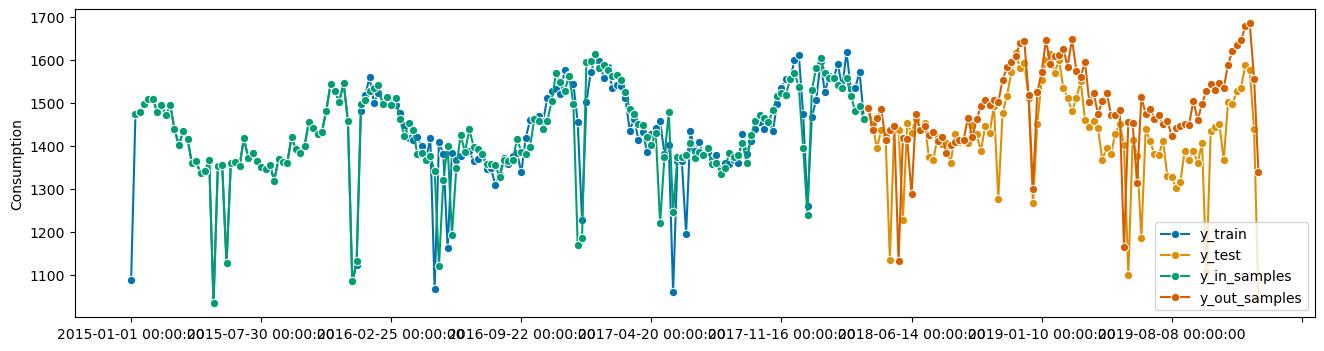

In [79]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = model.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = model.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Важно отметить, что полученный результат достигнут значтельно быстрее и имеет несколько меньшую ошибку. Однако оба фреймворка дают не оптимальный результат. Более того, отметим, что  результат работы таких моделей должен быть [тщательно протестирован](https://stackoverflow.com/questions/22770352/auto-arima-equivalent-for-python/22770973#22770973) чтобы принять решение о его валидности.

Другими словами помимо самой процедуры автопоиска параметров моделей базирующихся на информационных критериях только для тренировочной выборки необходимо также проводить [валидацию полученных моделей](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Model-tuning). В отличии от информационных критериев, которые имеют лишь некоторое относительное значение на этапе валидации должны быть использованы более известные метрики, такие как например `SMAPE` и  другие.  [Важно понимать](https://netman.aiops.org/~peidan/ANM2019/5.KPIAnomalyDetection/ReadingLists/time_series.pdf), что если первые из указанных критериев указывают на сложность модели в определенном понимании, то вторые на работу в конкретных условиях. СЛожность, как говорилось ранее важна с точки зрения априорной оценки обобщающей способности. В тоже время валидация указывает на свойства модели в конкретных условиях.

Можно дать [рекомендации](https://www.researchgate.net/publication/321613401_Business_Intelligence_Second_European_Summer_School_eBISS_2012_Brussels_Belgium_July_15-21_2012_Tutorial_Lectures):
* начальные предположения о порядках модели могут быть оценены при помощи `AutoARIMA` и выбранного информационного критерия. 
* Затем лучшие из моделей могут быть протестированы на наборе валидационных выборок чтобы определится. Отметим, что не рекомендуется использование одной валидационной выборке. Лучше разделить выборку на несколько последовательных (иногда пересекающихся) выборок и оценить метрику на каждой из них (аналог `k-folds`).
* Иногда могут также быть использованы и ансамбли моделей либо их бустинг. То есть или параллельное объеднение моделей. Либо каждая следующая модель строится на остатках от работы предыдущей.
* В ряде случаев допустимо использование отдельных моделей для отдельных участков ВР. При этом лучшая модель определяется, например, по критерию минимального расстояния (Локальные модели).Локальные модели могут оцениваться по нескольким отрезкам близки к текущему положени ВР (аналог `k-nearest neighbors`). 


Также отметим, что в рамках пакета `SKTime` доступны и другие методы работы с `ARMA` моделями. Например, вместо поиска производных можно провести предварительное удаление сезонности данных. 


sMAPE = 0.048


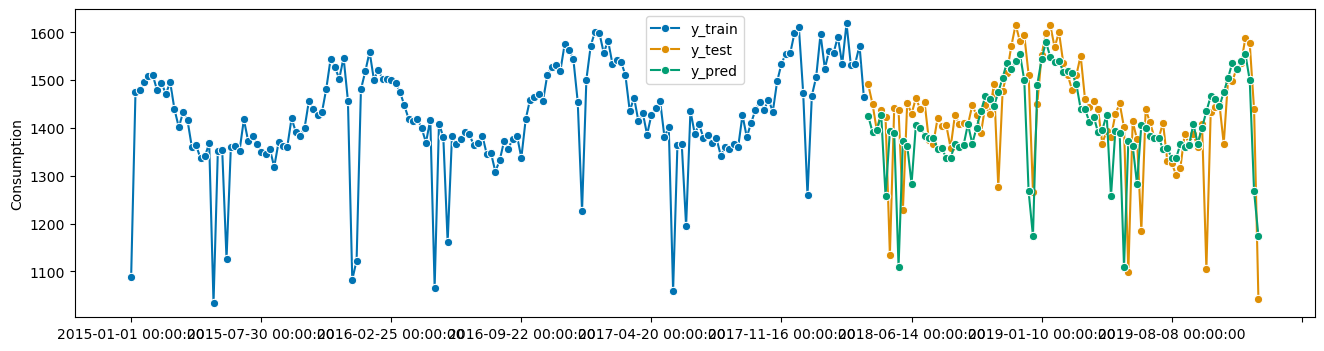

In [86]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", ARIMA( order=(1, 0, 0), seasonal_order=(0, 0, 0, 0),  )),
    ]
)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Точность такого результата оказывается несколько ниже, чем лучший из результатов, полученных выше. Однако, скорость обучения модели значительно увеличивается. Более того модель имеет всего `1` параметр авторегрессии. **Напомним, что чем меньше число компонент в модели, тем ниже вероятность переобучения**. Друигими словами чем меньше параметров модели, тем стабильней будут предсказания на длинном горизонте. (Переобчение для модели `ARIMA` анологично росту ошибки на длинном горизонте прогнозирования. Другими словами вилияние нестационарности на результат прогноза сродни переобучению модели). В дополнение к этому такой подход позволяет проводить раздельно учитывать несколько сезонных составляющих в данных.


На сегодняшний день семейство моделей `ARIMA` является одним из основных методов предсказания временных рядов. Метод отлично подходит для однопеменных временных рядов. Метод хорошо работает как для рядов небольшой длительности, так и для достаточно длинных рядов. При этом метод подходит как для детерминированных, так и для случайных типа тренд. А также, само по себе описание ряда при помощи коэффициентов может быть важным признаком в ряде методов машинного обучения. 


Отметим, что часто метод `ARIMA` сравнивается c алгоритмом `Prophet`, который в свою очередь представляет собой некоторую адоптацию обобщенной регрессии к бизнесс процессом. Алгоритм `Prophet` в некоторых случаях может давать более точные предсказания, но не всегда. Давайте сравним результаты, полученные методами `ARIMA` и `Prophet` для нашего примера.

19:49:53 - cmdstanpy - INFO - Chain [1] start processing
19:49:53 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.042


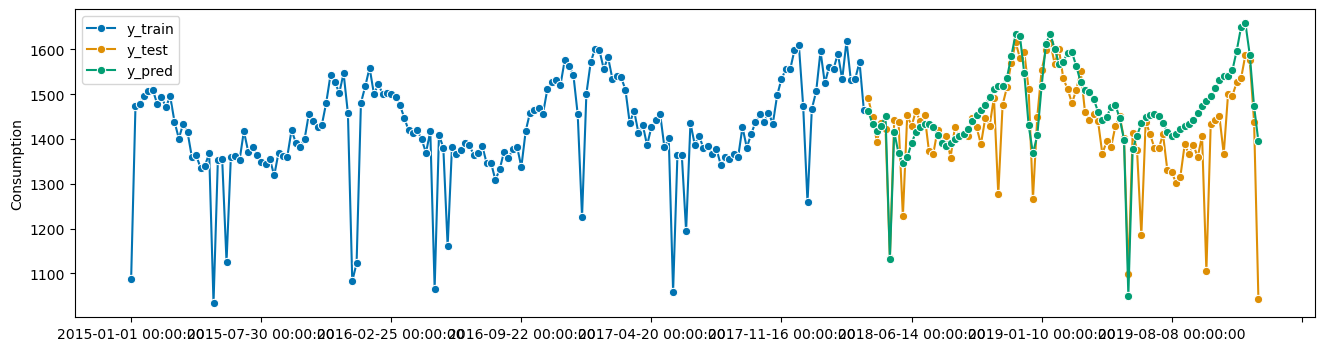

In [90]:
forecaster = Prophet(freq='1w',
                    seasonality_mode='additive',
                    add_country_holidays={'country_name': 'Germany'},
                    yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

После правильной настройки метод алгоритм `Prophet` оказался чуть лучше. Еще раз отметим, что в каждом случае следует выбирать свой вариант предсказателя.

<!-- from auto_ts import auto_timeseries
df = pd.DataFrame(y_train)
df["data"] = df.index.values
df.index = np.arange(len(df))
# df
#-----------------------------------
model = auto_timeseries(score_type='rmse',
                        time_interval='W',
                        non_seasonal_pdq=None, 
                        seasonality=False, 
                        seasonal_period=52,
                        model_type=['best'],
                        dask_xgboost_flag=False,
                        verbose=2)

model.fit(df, 'data','Consumption')
#-----------------------------------

df_test = pd.DataFrame(y_test)
df_test["data"] = df_test.index.values
df_test.index = np.arange(len(df_test))

predictions  = model.predict(df_test, model='best')
df_test['pred'] = predictions['yhat'].values
df_test.head()
#----------------------
y_pred = pd.DataFrame(df_test['pred'].values, index = y_test.index)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}') -->